# ROMY Barometer - Statistic Plots

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy import read_inventory

from andbro__read_sds import __read_sds

In [2]:
from functions.get_mean_promy_pressure import __get_mean_promy_pressure
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

In [3]:
#%matplotlib tk

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [86]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_baro/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_baro/data/"

config['tbeg'] = obs.UTCDateTime("2024-03-01")
# config['tend'] = obs.UTCDateTime("2024-06-30")
config['tend'] = obs.UTCDateTime("2024-05-01")

## Load Data

In [87]:
def __load_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime
    from tqdm.notebook import tqdm

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in tqdm(date_range(t1, t2)):
        # print(str(dat)[:10])
        file = f"RB_statistics_{str(dat)[:10]}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    # df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [(_t2 - _t1)/2 + _t1 for _t1, _t2 in zip(df.t1, df.t2)]

    return df

In [88]:
df = __load_data(config['tbeg'], config['tend'], config['path_to_data'])

  0%|          | 0/62 [00:00<?, ?it/s]

In [89]:
# df = pd.read_pickle(config['path_to_data']+"RB_statistics_2024-03-01_2024-03-10.pkl")

In [90]:
df = df[df.status == False]

In [91]:
df.keys()

Index(['t1', 't2', 'status', 'shift_PP_N', 'shift_PP_E', 'shift_PP_Z',
       'shift_HP_N', 'shift_HP_E', 'shift_HP_Z', 'cmax_PP_N', 'cmax_PP_E',
       'cmax_PP_Z', 'cmax_HP_N', 'cmax_HP_E', 'cmax_HP_Z', 'r_z', 'r_n', 'r_e',
       'a_z', 'a_n', 'a_e', 'b_z', 'b_n', 'b_e', 'wvel', 'wdir', 'time_sec'],
      dtype='object')

In [92]:
for k in ["shift_PP_N", "shift_PP_E", "shift_HP_N", "shift_HP_E"]:
    df[k] = df[k]/20 # 20 Hz sampling rate


In [93]:
# df = df[df.b_e != 0]

In [94]:
# select only those with CC > 0.7
cc_threshold = 0.7
dfN = df[(df.cmax_PP_N.abs() > cc_threshold) | (df.cmax_HP_N.abs() > cc_threshold)]
dfE = df[(df.cmax_PP_E.abs() > cc_threshold) | (df.cmax_HP_E.abs() > cc_threshold)]
dfZ = df[(df.cmax_PP_Z.abs() > cc_threshold) | (df.cmax_HP_Z.abs() > cc_threshold)]

cc_shift_threshold = 120
dfN = dfN[(dfN.shift_PP_N.abs() < cc_shift_threshold) | (dfN.shift_HP_N.abs() < cc_shift_threshold)]
dfE = dfE[(dfE.shift_PP_E.abs() < cc_shift_threshold) | (dfE.shift_HP_E.abs() < cc_shift_threshold)]
dfZ = dfZ[(dfZ.shift_PP_Z.abs() < cc_shift_threshold) | (dfZ.shift_HP_Z.abs() < cc_shift_threshold)]

# print(dfN.shape, dfE.shape, dfN.shape)

# select only those with VR > 50 %
# vr_threshold = 40
# dfN = df[(df.r_n > vr_threshold)]
# dfE = df[(df.r_e > vr_threshold)]
# dfZ = df[(df.r_z > vr_threshold)]


dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
  label  lower_whisker  lower_quartile      median  upper_quartile  \
0   a_z       0.114109        1.906107    3.718573        6.580152   
1   a_n       0.045296       25.327816   42.679941       61.733197   
2   a_e       0.312585       32.572346   45.577207       59.337229   
3   b_z       5.174339       19.768881   25.986038       32.369601   
4   b_n       1.747567      157.327589  239.970946      351.729166   
5   b_e       2.165224       85.416256  144.292059      219.923059   

   upper_whisker  
0      13.230343  
1     113.363493  
2      94.730413  
3      47.200015  
4     624.001876  
5     404.603046  


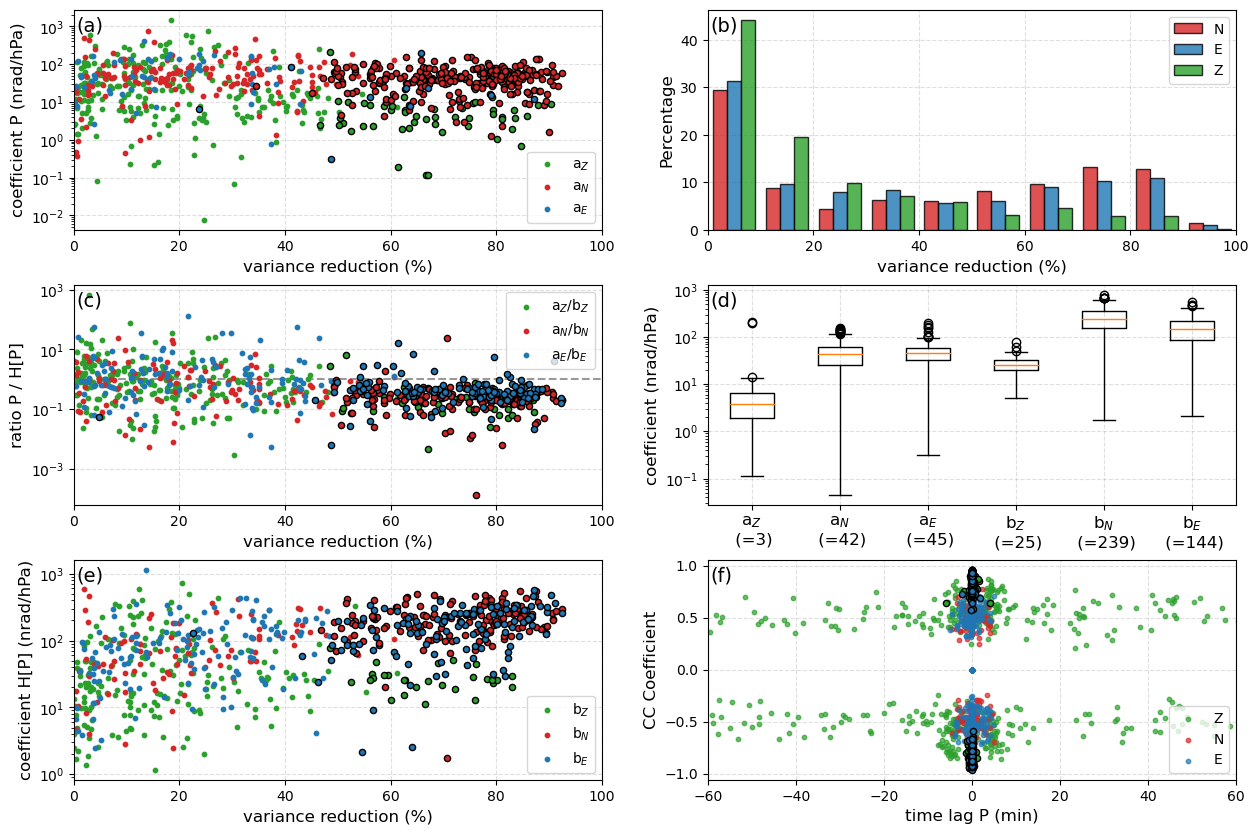

In [140]:
def __makeplot():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    def get_box_plot_data(labels, bp):
        rows_list = []

        for i in range(len(labels)):
            dict1 = {}
            dict1['label'] = labels[i]
            dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
            dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
            dict1['median'] = bp['medians'][i].get_ydata()[1]
            dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
            dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
            rows_list.append(dict1)

        return pd.DataFrame(rows_list)

    def __get_medians(_dict, _lbls):
        medians = {}
        for _i, _l in enumerate(_lbls):
            medians[str(_l)] = _dict['medians'][_i].get_ydata()[1]
        return medians

    colors = {"Z":"tab:green", "N":"tab:red", "E":"tab:blue"}

    Nrow, Ncol = 3, 2

    font = 12

    ms1, ms2 = 10, 20

    scale, unit = 1e9, "nrad/hPa"

    hil = r"H[P]"

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.25)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])

    # ___________________________________________________
    ax0.scatter(df.r_z, df.a_z*scale, s=ms1, color=colors["Z"], label=r"a$_Z$", zorder=2)
    ax0.scatter(df.r_n, df.a_n*scale, s=ms1, color=colors["N"], label=r"a$_N$", zorder=2)
    ax0.scatter(df.r_e, df.a_e*scale, s=ms1, color=colors["E"], label=r"a$_E$", zorder=2)
    ax0.scatter(dfZ.r_z, dfZ.a_z*scale, s=ms2, color=colors["Z"], zorder=2, edgecolor="k")
    ax0.scatter(dfN.r_n, dfN.a_n*scale, s=ms2, color=colors["N"], zorder=2, edgecolor="k")
    ax0.scatter(dfE.r_e, dfE.a_e*scale, s=ms2, color=colors["E"], zorder=2, edgecolor="k")
    ax0.legend(fontsize=font-2)
    ax0.set_yscale("log")
    ax0.set_xlim(0, 100)
    ax0.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax0.set_ylabel(f"coefficient P ({unit})", fontsize=font)

    # ___________________________________________________
    Nmax = df.shape[0]
    weights=[np.ones(Nmax)/Nmax*100, np.ones(Nmax)/Nmax*100, np.ones(Nmax)/Nmax*100]
    ax1.hist([df.r_n, df.r_e, df.r_z], bins=10, range=[0, 100], alpha=0.8,
             density=False, weights=weights,
             rwidth=0.8, align="mid", zorder=2, edgecolor="k",
             color=[colors["N"], colors["E"], colors["Z"]], label=["N", "E", "Z"],
            )
    ax1.grid(alpha=0.2, ls="--", zorder=0)
    ax1.set_xlim(0, 100)
    ax1.legend(fontsize=font-2)
    ax1.set_xlabel(f"variance reduction (%)", fontsize=font)
    # ax1.set_ylabel(f"count of {Nmax}", fontsize=font)
    ax1.set_ylabel(f"Percentage", fontsize=font)

    # ___________________________________________________
    ax2.scatter(df.r_z, (df.a_z*scale)/(df.b_z*scale), s=ms1, color=colors["Z"], label=r"a$_Z$/b$_Z$", zorder=2)
    ax2.scatter(df.r_n, (df.a_n*scale)/(df.b_n*scale), s=ms1, color=colors["N"], label=r"a$_N$/b$_N$", zorder=2)
    ax2.scatter(df.r_e, (df.a_e*scale)/(df.b_e*scale), s=ms1, color=colors["E"], label=r"a$_E$/b$_E$", zorder=2)
    ax2.scatter(dfZ.r_z, (dfZ.a_z*scale)/(dfZ.b_z*scale), s=ms2, color=colors["Z"], zorder=2, edgecolor="k")
    ax2.scatter(dfN.r_n, (dfN.a_n*scale)/(dfN.b_n*scale), s=ms2, color=colors["N"], zorder=2, edgecolor="k")
    ax2.scatter(dfE.r_e, (dfE.a_e*scale)/(dfE.b_e*scale), s=ms2, color=colors["E"], zorder=2, edgecolor="k")
    ax2.axhline(1, 0, 100, color="grey", alpha=0.8, zorder=0, ls="--")
    ax2.legend(fontsize=font-2)
    # ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 100)
    ax2.set_yscale("log")
    ax2.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax2.set_ylabel(f"ratio P / {hil}", fontsize=font)

    # ___________________________________________________
    # ax3.boxplot([abs(df.a_z*scale), abs(df.a_n*scale), abs(df.a_e*scale), abs(df.b_z*scale), abs(df.b_n*scale), abs(df.b_e*scale)],)
    a_z, a_n, a_e = abs(dfZ.a_z*scale), abs(dfN.a_n*scale), abs(dfE.a_e*scale)
    b_z, b_n, b_e = abs(dfZ.b_z*scale), abs(dfN.b_n*scale), abs(dfE.b_e*scale)
    arr = [a_z, a_n, a_e, b_z, b_n, b_e]
    bp = ax3.boxplot(arr, showmeans=False)
    ax3.set_yscale("log")
    meds = __get_medians(bp, ['a_z', 'a_n', 'a_e', 'b_z', 'b_n', 'b_e'])
    lbls = [f"a$_Z$ \n (={int(meds['a_z'])})", f"a$_N$ \n (={int(meds['a_n'])})", f"a$_E$ \n (={int(meds['a_e'])})",
            f"b$_Z$ \n (={int(meds['b_z'])})", f"b$_N$ \n (={int(meds['b_n'])})", f"b$_E$ \n (={int(meds['b_e'])})"]
    ax3.set_xticklabels(lbls, fontsize=font)
    ax3.set_ylabel(f"coefficient ({unit})", fontsize=font)

    # ___________________________________________________
    ax4.scatter(df.r_z, df.b_z*scale, s=ms1, color=colors["Z"], label=r"b$_Z$", zorder=2)
    ax4.scatter(df.r_n, df.b_n*scale, s=ms1, color=colors["N"], label=r"b$_N$", zorder=2)
    ax4.scatter(df.r_e, df.b_e*scale, s=ms1, color=colors["E"], label=r"b$_E$", zorder=2)
    ax4.scatter(dfZ.r_z, dfZ.b_z*scale, s=ms2, color=colors["Z"], zorder=2, edgecolor="k")
    ax4.scatter(dfN.r_n, dfN.b_n*scale, s=ms2, color=colors["N"], zorder=2, edgecolor="k")
    ax4.scatter(dfE.r_e, dfE.b_e*scale, s=ms2, color=colors["E"], zorder=2, edgecolor="k")
    ax4.legend(fontsize=font-2)
    ax4.set_yscale("log")
    ax4.set_xlim(0, 100)
    ax4.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax4.set_ylabel(f"coefficient {hil} ({unit})", fontsize=font)

    # ___________________________________________________
    tscale = 1/60

    # ax5.scatter(df.shift_PP_N*tscale, df.shift_HP_N, s=ms1,
    #             color=colors["N"], label=r"N", zorder=2)
    # ax5.scatter(df.shift_PP_E*tscale, df.shift_HP_E, s=ms1,
    #             color=colors["E"], label=r"E", zorder=2)
    # ax5.scatter(df.shift_PP_Z*tscale, df.shift_HP_Z, s=ms1,
    #             color=colors["Z"], label=r"Z", zorder=2)
    # ax5.scatter(dfN.shift_PP_N*tscale, dfN.shift_HP_N, s=ms2,
    #             color=colors["N"], label=f"N (CC>{cc_threshold})", zorder=2, edgecolor="k")
    # ax5.scatter(dfE.shift_PP_E*tscale, dfE.shift_HP_E, s=ms2,
    #             color=colors["E"], label=f"E (CC>{cc_threshold})", zorder=2, edgecolor="k")
    # ax5.scatter(dfZ.shift_PP_Z*tscale, dfZ.shift_HP_Z, s=ms2,
    #             color=colors["Z"], label=f"Z (CC>{cc_threshold})", zorder=2, edgecolor="k")
    # ax5.set_xlabel(f"time lag P (min)", fontsize=font)
    # ax5.set_ylabel(f"time lag {hil} (s)", fontsize=font)

    ax5.scatter(df.shift_PP_Z*tscale, df.cmax_PP_Z, s=ms1,
                color=colors["Z"], label=r"Z", zorder=2, alpha=0.7)
    ax5.scatter(df.shift_PP_N*tscale, df.cmax_PP_N, s=ms1,
                color=colors["N"], label=r"N", zorder=2, alpha=0.7)
    ax5.scatter(df.shift_PP_E*tscale, df.cmax_PP_E, s=ms1,
                color=colors["E"], label=r"E", zorder=2, alpha=0.7)
    ax5.scatter(dfZ.shift_HP_Z*tscale, dfZ.cmax_HP_Z, s=ms2,
                color=colors["Z"], zorder=2, edgecolor="k")
    ax5.scatter(dfN.shift_HP_N*tscale, dfN.cmax_HP_N, s=ms2,
                color=colors["N"], zorder=2, edgecolor="k")
    ax5.scatter(dfE.shift_HP_E*tscale, dfE.cmax_HP_E, s=ms2,
                color=colors["E"], zorder=2, edgecolor="k")

    ax5.set_xlabel(f"time lag P (min)", fontsize=font)
    ax5.set_ylabel(f"CC Coefficient", fontsize=font)

    # rmin, rmax = -30, 30
    # nbins = 100
    # ax5.hist(df.shift_PP_N*tscale, bins=nbins, range=[rmin, rmax],
    #          color=colors["N"], label=r"N", zorder=2, log=True)
    # ax5.hist(df.shift_PP_E*tscale, bins=nbins, range=[rmin, rmax],
    #          color=colors["E"], label=r"E", zorder=2, log=True)
    # ax5.hist(df.shift_PP_Z*tscale, bins=nbins, range=[rmin, rmax],
    #          color=colors["Z"], label=r"Z", zorder=2, log=True)
    # ax5.hist(dfN.shift_HP_N, bins=nbins, range=[rmin, rmax],
    # color=colors["N"], label=f"N (CC>{cc_threshold})", zorder=2)
    # ax5.hist(dfE.shift_HP_E, bins=nbins, range=[rmin, rmax],
    # color=colors["E"], label=f"E (CC>{cc_threshold})", zorder=2)
    # ax5.hist(dfZ.shift_HP_Z, bins=nbins, range=[rmin, rmax],
    # color=colors["Z"], label=f"Z (CC>{cc_threshold})", zorder=2)

    ax5.legend(fontsize=font-2, loc=4)
    # ax5.set_ylim(-2, 2)
    ax5.set_xlim(-60, 60)
    # ax5.set_xlabel(f"time lag P (min)", fontsize=font)
    # ax5.set_ylabel(f"time lag {hil} (s)", fontsize=font)

    ax0.text(.005, .97,"(a)", ha='left', va='top', transform=ax0.transAxes, fontsize=font+2)
    ax1.text(.005, .97,"(b)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97,"(c)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97,"(d)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97,"(e)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97,"(f)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)


    axes = [ax0, ax1, ax2, ax3, ax4, ax5]
    for ax in axes:
        ax.grid(ls="--", alpha=0.4, zorder=0)

    print(bp.keys())
    print(get_box_plot_data(["a_z", "a_n", "a_e", "b_z", "b_n", "b_e"], bp))

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"RB_statistic_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


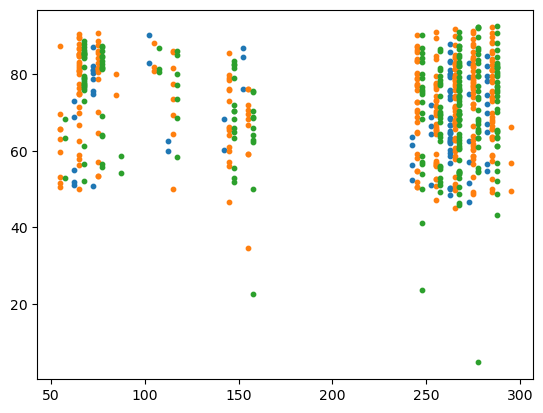

In [125]:
dw = 2.5

plt.scatter(dfZ.wdir-dw, dfZ.r_z, s=10)
plt.scatter(dfN.wdir, dfN.r_n, s=10)
plt.scatter(dfE.wdir+dw, dfE.r_e, s=10)

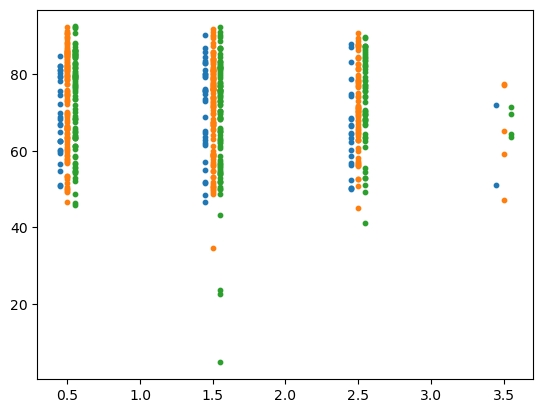

In [119]:
dv = 0.05
plt.scatter(dfZ.wvel-dv, dfZ.r_z, s=10)
plt.scatter(dfN.wvel, dfN.r_n, s=10)
plt.scatter(dfE.wvel+dv, dfE.r_e, s=10)